# Análisis de datos BB1- LHCO 2020

En este notebook intentaremos entender la distribución y relaciones de los datos R&D del LHC Olympics 2020. Los datos se pueden descargar de [este link](https://zenodo.org/record/4536377).
El código está basado en [este notebook](https://github.com/lhcolympics2020/parsingscripts/blob/master/LHCOlympics2020_pyjetexample.ipynb).

In [1]:
# Importamos las librerías a utilizar
import h5py                             # Para manejar los archivos .h5
import numpy as np                      # Manejo de matrices
import matplotlib.pyplot as plt         # Plots
from pyjet import cluster,DTYPE_PTEPM   # Clustering de los jets
import pandas as pd                     # Manejo de tablas
import os.path                          # Manejo de directorios
from os import path
from io import StringIO

## Lectura de datos

In [2]:
# leemos el archivo como un DataFrame de pandas
df_datos = pd.read_hdf("../events_LHCO2020_BlackBox1.h5")

In [3]:
# leemos el archivo con el key. Es un archivo ASCII donde cada linea corresponde a la información de señal o fondo
with open("../events_LHCO2020_BlackBox1.masterkey", 'r') as f:
    data = f.read()
# Lo convertimos en dataframe
df_senal = pd.read_csv(pd.compat.StringIO(data), header=None)
# Le cambiamos el nombre a la columna para que al concatenar con los datos no tenga el mismo nombre que otra columna
df_senal = df_senal.rename(columns={0: 2100})
df_senal.head()

,2100
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [4]:
# Concatenamos la fila de señal a los datos
df = pd.concat([df_datos[:100000],df_senal[:100000]], axis = 1)

In [5]:
# Vemos como luce el DataFrame
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.458914,-0.379456,-1.951695,0.168617,-2.059000,1.891684,0.484932,-0.441487,-1.710812,3.290530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.445335,-1.520769,2.598182,0.690283,-0.586618,-1.604517,4.675176,-0.446578,2.169639,1.580536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333176,-1.167212,-0.804673,0.436526,-0.800655,-2.126721,1.308002,-1.901752,-2.301318,0.149772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.533839,-0.152718,-0.893459,0.289985,-1.696549,0.133896,1.422378,-1.847963,-0.019029,2.196803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.155427,-0.112992,-3.074802,0.183135,-2.143614,-2.697274,0.485556,-0.392953,1.685330,0.537827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El archivo tiene un evento por fila. Cada fila está compuesta por:
- al menos un jet anti-kT R = 1.0 
- con pseudorapidez $|\eta|<2,5$ 
- y momento transversal $pT> 1,2$ TeV. 

Para cada evento, hay una lista de todos los hadrones:

|Evento|$pT$ | $\eta$ | $\phi$ | $pT$ | $\eta$ | $\phi$ | $\cdots$ | Señal? |
|------|-----|--------|--------|------|--------|--------|--------|--------|
| 1    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 1.0|
| 2    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|
| $\vdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|


con relleno de ceros hasta 700 hadrones.


In [6]:
# Sin embargo, tenemos muchos eventos
df.shape

(100000, 2101)

Haremos la exploración de los datos en un conjunto más pequeño de eventos:

In [7]:
# Para el análisis, escogemos 1000 eventos de la muestra
n_eventos = 10000

In [8]:
dfsample = df.sample(n=n_eventos)

In [9]:
# Los guardamos en un archivo .h5 para tener la muestra en la que se haga el análisis
if path.exists("events_LHCO2020_BlackBox1_tiny_{}.h5".format(n_eventos))!= True: 
    dfsample.to_hdf("events_LHCO2020_BlackBox1_tiny_{}.h5".format(n_eventos), key='df', mode='w',complevel=5,complib='blosc')

In [10]:
# Utilizamos estos datos para el análisis
eventos_tiny = pd.read_hdf("events_LHCO2020_BlackBox1_tiny_{}.h5".format(n_eventos))

In [11]:
# Tenemos un dataframe de 
# 1000 eventos x 700 hadrones * 3 características ( pT, eta, phi) + 1 columna (si es señal o fondo)
# El dataframe debe ser 1000x2101

np.shape(eventos_tiny)

(10000, 2101)

La última columna tiene la información sobre si el evento es señal(1) o fondo(0)

In [12]:
eventos_tiny.iloc[:,-1].head()

7191     0.0
65161    0.0
93169    0.0
66972    0.0
7715     0.0
Name: 2100, dtype: float64

Podemos saber el porcentaje de señal y de fondo en la muestra:

In [13]:
# Separamos el dataframe en señal y fondo
senal = eventos_tiny.loc[eventos_tiny.iloc[:,-1] == 1.0]
fondo = eventos_tiny.loc[eventos_tiny.iloc[:,-1] == 0.0]

# Obtenemos el numero de eventos (filas) del dataframe de señal, fondo y el de la muestra
n_senal = senal.shape[0]
n_fondo = fondo.shape[0]
n_eventos = eventos_tiny.shape[0]

# obtenemos la columna de señal de dataframe con todos los eventos
columna_senal = df.iloc[:,-1]

# separamos señal y fondo 
senaldf = columna_senal.loc[columna_senal == 1.0]
fondodf = columna_senal.loc[columna_senal == 0.0]

# Obtenemos el número de eventos (filas) del dataframe de señal, fondo y el de todos los eventos
ndf_senal = senaldf.shape[0]
ndf_fondo = fondodf.shape[0]
n_eventosdf = df.shape[0]

print('El {}% de los datos en la muestra de {} eventos es señal y el {}% es fondo'.format(n_senal/n_eventos*100,n_eventos,n_fondo/n_eventos*100 ))
print('El {}% de los datos R&D es señal y el {}% es fondo'.format(ndf_senal/n_eventosdf*100,ndf_fondo/n_eventosdf*100 ))

El 0.11% de los datos en la muestra de 10000 eventos es señal y el 99.89% es fondo
El 0.08% de los datos R&D es señal y el 99.92% es fondo


La ventaja de tener los datos en un dataframe es que podemos **utilizar la información fácilmente**.

Por ejemplo, para el clustering vamos a utilizar una lista que contenga los pT de cada jet si estos son mayores que 0.

In [14]:
# Por ejemplo, para el primer evento
lista= [data for data in eventos_tiny.iloc[0,::3] if data > 0] # pT, eta, phi, pT... Los pT están cada 3

# Vemos los primeros elementos
lista[0:5]

[0.3147481679916382,
 1.1998845338821411,
 1.0430494546890259,
 2.1851041316986084,
 3.166937828063965]

In [15]:
# el largo de cada lista varía según el evento. Esto representa la cantidad de hadrones por evento.
for evento in range(5):
    # Quitamos la fila de señal para no contarla como parte de los datos
    eventos_ss = eventos_tiny.iloc[:,:-1]  
    
    lista = [data for data in eventos_ss.iloc[evento,::3] if data > 0]
    print("Cantidad de hadrones en evento {}: {}".format(evento, len(lista)))

Cantidad de hadrones en evento 0: 129
Cantidad de hadrones en evento 1: 126
Cantidad de hadrones en evento 2: 182
Cantidad de hadrones en evento 3: 129
Cantidad de hadrones en evento 4: 127


Calculamos el **número promedio de hadrones** para los eventos de señal y de fondo:

In [16]:
def plot_dist(fondo, senal, xlabel, ylabel, titulo, n_bins=50):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    if type(fondo)==list:
        plt.hist(fondo, bins=n_bins, facecolor='b', alpha=0.2,label='fondo', density=True)
        plt.hist(senal, bins=n_bins, facecolor='r', alpha=0.2,label='señal', density=True)
        
    else:
       # Hacemos los histogramas
        fondo.plot.hist(bins=n_bins, facecolor='b', alpha=0.2, label='fondo', density=True)
        senal.plot.hist(bins=n_bins, facecolor='r', alpha=0.2, label='señal', density=True)

    # Agregamos información al gráfico
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.title(titulo)
    
    return plt.show()

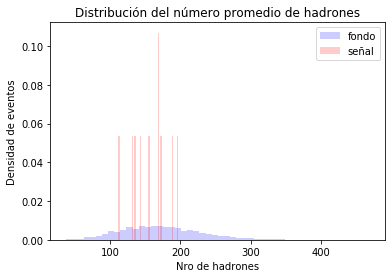

El número promedio de hadrones en los eventos de señal: 155 y en los eventos de fondo: 173


In [17]:
contar_h = eventos_tiny.copy()

# Quitamos la fila de señal para no contarla como parte de los datos
contar_h_ss = contar_h.iloc[:,:-1]
contar_h['Nro_hadrones'] = contar_h_ss.astype(bool).sum(axis=1)/3

h_senal = contar_h['Nro_hadrones'].loc[contar_h.iloc[:,-2] == 1.0]        # -2 porque al crear la columna Nro_hadrones,
h_fondo = contar_h['Nro_hadrones'].loc[contar_h.iloc[:,-2] == 0.0]        # la de señal ya no es la última

# Graficamos
plot_dist(h_fondo, h_senal, 
          r'Nro de hadrones', r'Densidad de eventos', 
          r'Distribución del número promedio de hadrones')

print('El número promedio de hadrones en los eventos de señal: {} y en los eventos de fondo: {}'.format(int(h_senal.mean()), int(h_fondo.mean())))

Podemos hacer dataframes de solamente pT, eta o phi

In [18]:
# pT está cada 3, partiendo de 0.
pt_df = eventos_tiny.iloc[:,::3]

pt_df.head()

,0,3,6,9,12,15,18,21,24,27,...,2073,2076,2079,2082,2085,2088,2091,2094,2097,2100
7191,0.314748,1.199885,1.043049,2.185104,3.166938,6.149646,4.409474,3.731068,2.078437,0.912334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65161,0.352608,0.456142,0.844040,0.366905,12.970077,7.259178,171.021622,69.081947,96.818115,294.903534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93169,0.227330,0.444353,0.093297,0.148719,0.432073,1.261089,0.598082,0.238813,0.554829,2.117441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66972,0.589901,0.415152,1.660720,1.245735,1.389055,0.951389,1.862138,2.289658,3.779310,1.838303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7715,0.207380,2.006686,0.123629,2.369005,4.583583,3.760519,1.660704,488.663391,6.334784,9.290866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Hacemos lo mismo con eta y phi

# Definimos la columna con la información de señal o fondo
senal_column = eventos_tiny[2100]

# Concatenamos esta a los slicing de los dataframe
eta_df = pd.concat([eventos_tiny.iloc[:,1::3],senal_column], axis = 1)
phi_df = pd.concat([eventos_tiny.iloc[:,2::3],senal_column], axis = 1)

### Gráficas de la media

Antes del clustering, podemos graficar la distribución de los datos para cada evento.

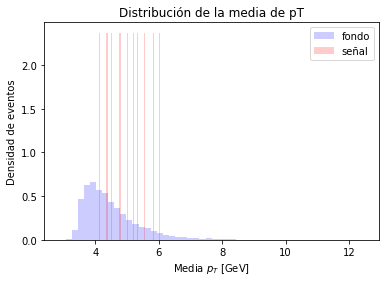

In [20]:
# Distribución de la media de pT para cada evento

# Filtramos que elementos son señal o fondo
pt_senal = pt_df.loc[pt_df.iloc[:,-1] == 1.0]
pt_fondo = pt_df.loc[pt_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
pt_senal = pt_senal.iloc[:,:-1]
pt_fondo = pt_fondo.iloc[:,:-1]

# Calculamos la media de las filas
meanpt_fondo = pt_fondo.mean(axis=1)
meanpt_senal = pt_senal.mean(axis=1)

# Graficamos
plot_dist(meanpt_fondo, meanpt_senal, 
          r'Media $p_{T}$ [GeV]', r'Densidad de eventos', 
          r'Distribución de la media de pT')

Podemos hacer lo mismo para $\eta$ y $\phi$:

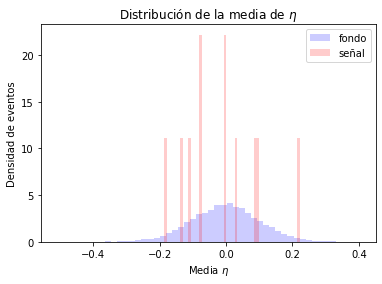

In [21]:
# Distribución de la media de eta para cada evento

# Filtramos que elementos son señal o fondo
eta_senal = eta_df.loc[eta_df.iloc[:,-1] == 1.0]
eta_fondo = eta_df.loc[eta_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
eta_senal = eta_senal.iloc[:,:-1]
eta_fondo = eta_fondo.iloc[:,:-1]

# Calculamos la media de las filas y hacemos un histograma
meaneta_fondo = eta_fondo.mean(axis=1)
meaneta_senal = eta_senal.mean(axis=1)

# Graficamos
plot_dist(meaneta_fondo, meaneta_senal, 
          r'Media $\eta$', r'Densidad de eventos', 
          r'Distribución de la media de $\eta$')

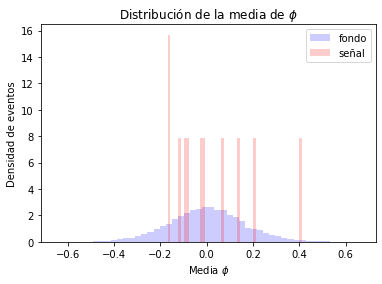

In [22]:
# Distribución de la media de phi para cada evento

# Filtramos que elementos son señal o fondo
phi_senal = phi_df.loc[phi_df.iloc[:,-1] == 1.0]
phi_fondo = phi_df.loc[phi_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
phi_senal = phi_senal.iloc[:,:-1]
phi_fondo = phi_fondo.iloc[:,:-1]


# Calculamos la media de las filas y hacemos un histograma
meanphi_fondo = phi_fondo.mean(axis=1)
meanphi_senal = phi_senal.mean(axis=1)

plot_dist(meanphi_fondo, meanphi_senal, 
          r'Media $\phi$', r'Densidad de eventos', 
          r'Distribución de la media de $\phi$')

### Gráficas del hadrón más energético

Analizamos el hadron más energético. Para esto hallaremos el mayor pT en cada evento

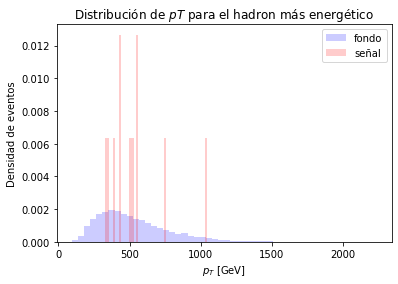

In [23]:
# Distribución de la pT para hadron mas energetico en cada evento

# Hallamos el maximo en cada fila para señal y fondo
ptmax_senal = pt_senal.max(axis=1)
ptmax_fondo = pt_fondo.max(axis=1)

# Hallamos los nombres de las columnas. Lo usaremos para obtener eta y phi de este hadron
col_ptmax_s = pt_senal.idxmax(axis=1)
col_ptmax_f = pt_fondo.idxmax(axis=1)

# Graficamos
plot_dist(ptmax_fondo, ptmax_senal, 
          r'$p_{T}$ [GeV]', r'Densidad de eventos', 
          r'Distribución de $pT$ para el hadron más energético')

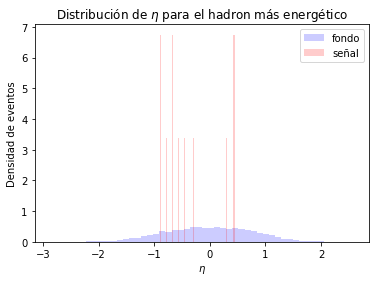

In [24]:
# Hallamos la columna con eta del hadron mas energetico. Es la siguiente a la de pT mas energetico.
col_etamax_s = col_ptmax_s + 1 
col_etamax_f = col_ptmax_f + 1

# Hacemos el mapeo de las columnas para extraerlas del dataframe
# https://stackoverflow.com/questions/50341927/select-pandas-column-for-each-row-by-index-list

etamax_senal = pd.Series(eta_senal.lookup(col_etamax_s.index, col_etamax_s.values))
etamax_fondo = pd.Series(eta_fondo.lookup(col_etamax_f.index, col_etamax_f.values))

# Graficamos

plot_dist(etamax_fondo, etamax_senal, 
          r'$\eta$', r'Densidad de eventos', 
          r'Distribución de $\eta$ para el hadron más energético')

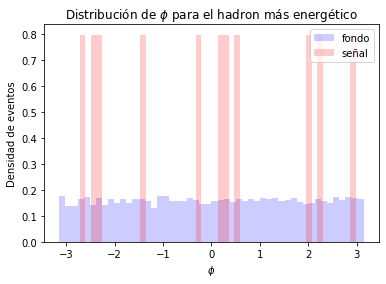

In [25]:
# Hallamos la columna con eta del hadron mas energetico. Es la segunda siguiente a la de pT mas energetico.
col_phimax_s = col_ptmax_s + 2 
col_phimax_f = col_ptmax_f + 2

# Hacemos el mapeo de las columnas para extraerlas del dataframe
phimax_senal = pd.Series(phi_senal.lookup(col_phimax_s.index, col_phimax_s.values))
phimax_fondo = pd.Series(phi_fondo.lookup(col_phimax_f.index, col_phimax_f.values))

# Graficamos
plot_dist(phimax_fondo, phimax_senal, 
          r'$\phi$', r'Densidad de eventos', 
          r'Distribución de $\phi$ para el hadron más energético')

## Clustering

Para el clustering vamos a usar la librería <code>pyjet</code>. Esta librería permite hacer el clustering de los jets mediante FastJet y arreglos de NumPy. 

**FastJet** posee 3 clases principales que formarán parte del clustering:
- *PseudoJets*: provee un jet con cuadri-momento y algunos indices internos para situarlo en el contexto de una secuencia de clustering de jets.
- *JetDefinition*: contiene especificaciones sobre cómo se hará el clustering
- *ClusterSequence*: la clase que lleva a cabo el clustering y provee acceso a los jets finales.

Como input tenemos los 1000 eventos con hasta 700 hadrones y como output tendremos:
- Un diccionario con los jets de fondo y de señal en objetos PseudoJets
- Tres diccionario separado en señal y fondo con:
   - $pT$ del jet principal de cada evento
   - $\eta$ del jet principal de cada evento
   - $\phi$ del jet principal de cada evento


El código para el clustering es el siguiente:

In [26]:
# Creamos las variables a utilizar
alljets={}                                     # diccionario con los jets de cada evento y su información
leadpT={}                                      # diccionario de pT del jet principal de cada evento
leadeta={}                                     # diccionario de eta del jet principal de cada evento
leadphi={}                                     # diccionario de phi del jet principal de cada evento
n_eventos = eventos_tiny.shape[0]              # número de eventos (1000)
n_hadrones = int((eventos_tiny.shape[1]-1)/3)  # número de hadrones (700) 
                                               # [-1 para eliminar la columna señal, /3 por las 3 caracteristicas de cada hadron]

print('CLUSTERING DE JETS')
print("En estos datos hay {} eventos y {} hadrones p/evento".format(n_eventos, n_hadrones))

for mitipo in ['fondo','senal']:
    # Creamos el key para cada diccionario 
    alljets[mitipo]=[] 
    leadpT[mitipo]=[]
    leadeta[mitipo]=[]  
    leadphi[mitipo]=[]
    
    for evento in range(n_eventos):
        # Indicamos que el código está corriendo
        if (evento%1000==0):
            print(mitipo,evento)
            pass
        
        # La última columna tiene la información sobre si el evento es señal(1) o fondo(0)
        essenal = eventos_tiny.iloc[evento,-1]
        
        # Si estamos en fondo solo analizamos los eventos que son fondo y viceversa.
        if (mitipo=='fondo' and essenal):
            continue
        elif (mitipo=='senal' and essenal==0):
             continue            
        
        # Eliminamos la columna de señal para evitar problemas al obtener el pT (porque cuando es señal es >0)
        eventos_tiny_ss = eventos_tiny.iloc[:,:-1]
        
        # Creamos un numpy array de ceros del tamaño de la cantidad de datos distintos de cero que hay en el evento
        # ** Buscar que es  pyjet DTYPE_PTEPM **
        pseudojets_input = np.zeros(len([data for data in eventos_tiny_ss.iloc[evento,::3] if data > 0]), dtype=DTYPE_PTEPM) 
        
        for hadron in range(n_hadrones):
            if (eventos_tiny.iloc[evento,hadron*3]>0): ## si pT > 0 
                
                ## Llenamos el arreglo con pT, eta y phi de cada "partícula"
                pseudojets_input[hadron]['pT'] = eventos_tiny.iloc[evento,hadron*3] 
                pseudojets_input[hadron]['eta'] = eventos_tiny.iloc[evento,hadron*3+1]
                pseudojets_input[hadron]['phi'] = eventos_tiny.iloc[evento,hadron*3+2]
                
                pass
            pass
        
        ## Devuelve una "ClusterSequence" (un tipo de lista de pyjet)
        ## ** No sé en verdad que está haciendo la función. clustering con anti-kt? o con que? que es p? ## 
        secuencia = cluster(pseudojets_input, R=1.0, p=-1) 
        
        ## Con inclusive_jets accedemos a todos los jets que fueron clusterizados
        ## y filtramos los que tienen pT mayor que 20
        ## Hacemos una lista con objetos PseudoJet
        jets = secuencia.inclusive_jets(ptmin=20) 
        
        # Agrega el pT, eta y phi del jet principal
        # ** No sé cómo están en orden **
        leadpT[mitipo] += [jets[0].pt] 
        leadeta[mitipo] += [jets[0].eta] 
        leadphi[mitipo] += [jets[0].phi] 
        
        # agregamos todos los jets a alljets
        alljets[mitipo] += [jets] 
        
        ###################################CHEQUEANDO LOS TIPOS DE VARIABLES#############################################
        if evento==0 or evento==2000: 
            print('BREVE ANALISIS DE LAS VARIABLES')
            print('**pseudojets_input**: tipo {}, largo {}'.format(type(pseudojets_input), len(pseudojets_input)))
            print('**secuencia**: tipo {}'.format(type(secuencia)))
            print('**jets**: tipo {}, largo {}, tipo de objetos que contiene {}'.format(type(jets), len(jets), type(jets[0])))
            print('**leadpT**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(leadpT), len(leadpT), type(leadpT[mitipo][0])))
            print('**alljets**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(alljets), len(alljets), type(alljets[mitipo][0])))
            
        pass        

CLUSTERING DE JETS
En estos datos hay 10000 eventos y 700 hadrones p/evento
fondo 0
BREVE ANALISIS DE LAS VARIABLES
**pseudojets_input**: tipo <class 'numpy.ndarray'>, largo 129
**secuencia**: tipo <class 'pyjet._libpyjet.ClusterSequence'>
**jets**: tipo <class 'list'>, largo 4, tipo de objetos que contiene <class 'pyjet._libpyjet.PseudoJet'>
**leadpT**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'float'>
**alljets**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'list'>
fondo 1000
fondo 2000
BREVE ANALISIS DE LAS VARIABLES
**pseudojets_input**: tipo <class 'numpy.ndarray'>, largo 139
**secuencia**: tipo <class 'pyjet._libpyjet.ClusterSequence'>
**jets**: tipo <class 'list'>, largo 3, tipo de objetos que contiene <class 'pyjet._libpyjet.PseudoJet'>
**leadpT**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'float'>
**alljets**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'list'>
fondo 3000
fondo 4000
fondo 

Analicemos los datos para los jets reconstruidos. Veamos la distribución de jets reconstruidos para señal y fondo:

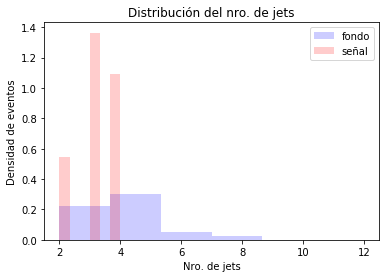

El número promedio de jets en los eventos de señal: 3 y en los eventos de fondo: 4


In [27]:
# Creamos un diccionario con la cantidad de jets reconstruidos por evento para señal y fondo
nro_jets = {}
for mitipo in alljets.keys():
    nro_jets[mitipo] = []
    nro_jets[mitipo] += [len(lista) for lista in alljets[mitipo]]

# Creamos series de los datos, para poder graficar fácilmente
nro_jets_fondo = pd.Series( (v for v in nro_jets['fondo']) )
nro_jets_senal = pd.Series( (v for v in nro_jets['senal']) )

# Graficamos
plot_dist(nro_jets_fondo, nro_jets_senal, 
          r'Nro. de jets', r'Densidad de eventos', 
          'Distribución del nro. de jets', n_bins=6)

print('El número promedio de jets en los eventos de señal: {} y en los eventos de fondo: {}'.format(int(nro_jets_senal.mean()), int(nro_jets_fondo.mean())))


### Gráficas

**Graficamos** la distribución de los valores de los jets principales:

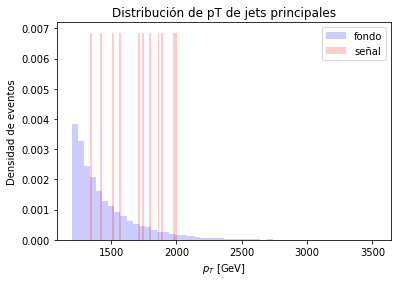

In [28]:
# Distribución de pT
plot_dist(leadpT['fondo'], leadpT['senal'], 
          r'$p_{T}$ [GeV]', 'Densidad de eventos', 
          'Distribución de pT de jets principales')

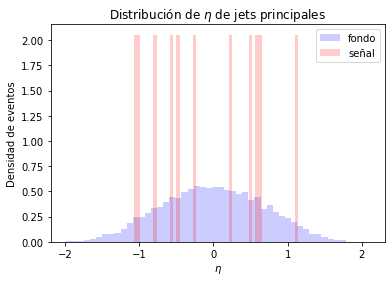

In [29]:
# Distribución de eta
plot_dist(leadeta['fondo'], leadeta['senal'], 
          r'$\eta$', 'Densidad de eventos', 
          'Distribución de $\eta$ de jets principales')

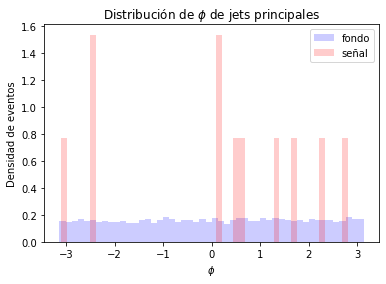

In [30]:
# Distribución de phi
plot_dist(leadphi['fondo'], leadphi['senal'], 
          r'$\phi$', 'Densidad de eventos', 
          'Distribución de $\phi$ de jets principales')

Utilizando funciones de FastJet sobre los objetos PseudoJets podemos calcular la masa invariante facilmente:

In [31]:
# MASA INVARIANTE
mjj={}

for mitipo in ['fondo','senal']:
    n_eventos = len(alljets[mitipo])
    mjj[mitipo]=[]
    
    for evento in range(n_eventos): 
        
        jet = alljets[mitipo][evento]
        
        # De cada evento sumamos la energía de los dos jets más energéticos
        E = jet[0].e + jet[1].e
        
        # Igual aqui pero con las componentes del momento
        px = jet[0].px + jet[1].px 
        py = jet[0].py + jet[1].py
        pz = jet[0].pz + jet[1].pz
        
        ## Calculamos la masa invariante
        mjj[mitipo]+=[(E**2-px**2-py**2-pz**2)**0.5] 
        pass
    pass

Y graficamos la distribución

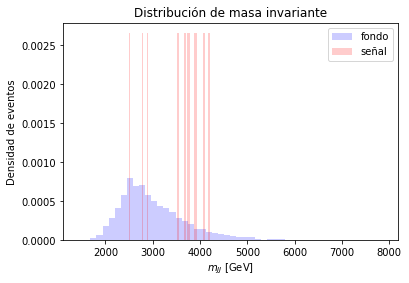

In [32]:
# Distribución de masa invariante
plot_dist(mjj['fondo'], mjj['senal'], 
          r'$m_{JJ}$ [GeV]', 'Densidad de eventos', 
          'Distribución de masa invariante')

In [33]:
# DISTANCIA ENTRE JETS 
distancia={}

for mitipo in ['fondo','senal']:
    n_eventos = len(alljets[mitipo])
    distancia[mitipo]=[]
    
    for evento in range(n_eventos): 
        
        jet = alljets[mitipo][evento]
        
        ## Calculamos la distancia
        distancia[mitipo]+=[( (jet[0].phi-jet[1].phi)**2+(jet[0].eta-jet[1].eta)**2 )**0.5] 
        pass
    pass

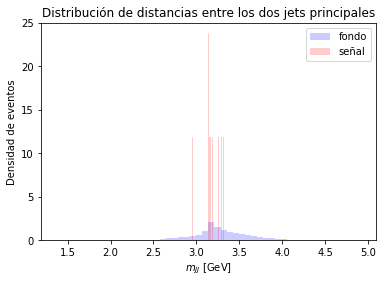

In [34]:
# Distribución de distancias
plot_dist(distancia['fondo'], distancia['senal'], 
          r'$m_{JJ}$ [GeV]', 'Densidad de eventos', 
          'Distribución de distancias entre los dos jets principales')

También podemos ver si hay alguna **relación entre las variables** graficando:

In [35]:
def plots_scatter(xfondo, yfondo, xsenal, ysenal, xlabel, ylabel, titulo):

    fig = plt.figure(figsize=[12, 4])

    # Creamos los subplots
    ax1 = fig.add_subplot(1,2, 1)
    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)

    # señal
    senal= ax2.scatter(xsenal, ysenal, c='r', alpha=0.5)
    ax2.label_outer()
    #ax2.set_title('Señal')

    # fondo
    fondo = ax1.scatter(xfondo, yfondo, c='b', alpha=0.5)
    ax1.set(ylabel=ylabel)
    #ax1.set_title('Fondo')

    # Colocamos el título y el eje x
    ax2.legend((senal, fondo), ('Señal', 'Fondo'), loc='upper right', prop={'size': 12})
    fig.suptitle(titulo)
    fig.text(0.5, 0.04, xlabel, ha='center', va='center')
    plt.subplots_adjust(wspace=0);
    
    return plt.show()

### Relación de la masa invariante con las demás variables

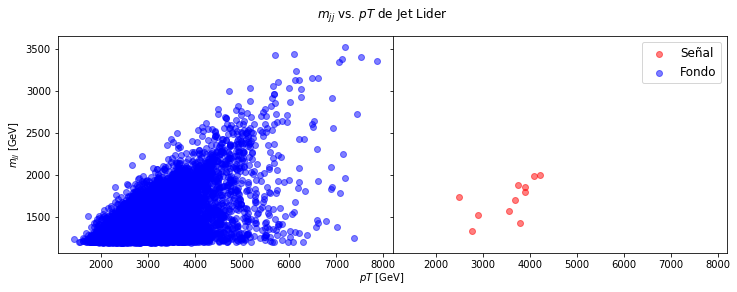

In [36]:
# Relación entre mjj y pT
plots_scatter(mjj['fondo'], leadpT['fondo'], 
              mjj['senal'], leadpT['senal'], 
              r'$pT$ [GeV]', r'$m_{jj}$ [GeV]', r'$m_{jj}$ vs. $pT$ de Jet Lider')

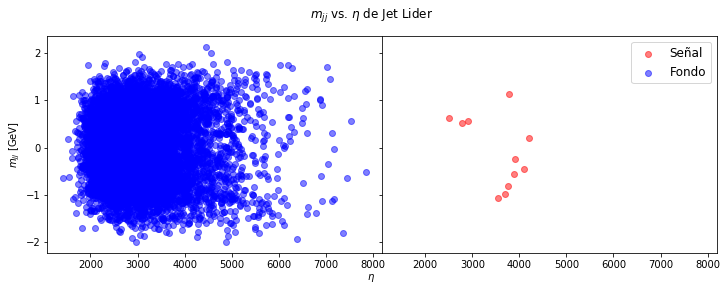

In [37]:
# Relación entre mjj y eta
plots_scatter(mjj['fondo'], leadeta['fondo'], 
              mjj['senal'], leadeta['senal'], 
              r'$\eta$', r'$m_{jj}$ [GeV]', r'$m_{jj}$ vs. $\eta$ de Jet Lider')

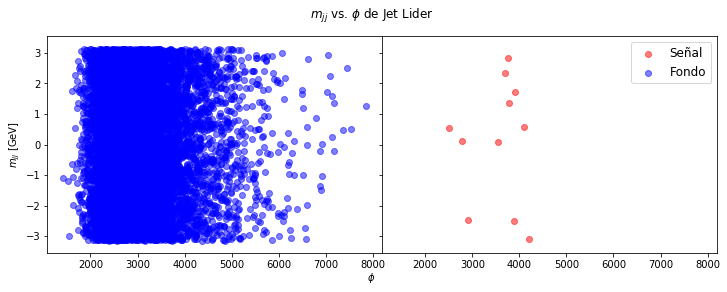

In [38]:
# Relación entre mjj y phi

plots_scatter(mjj['fondo'], leadphi['fondo'], 
              mjj['senal'], leadphi['senal'], 
              r'$\phi$', r'$m_{jj}$ [GeV]', r'$m_{jj}$ vs. $\phi$ de Jet Lider')

### Relación de pT con las demás variables 

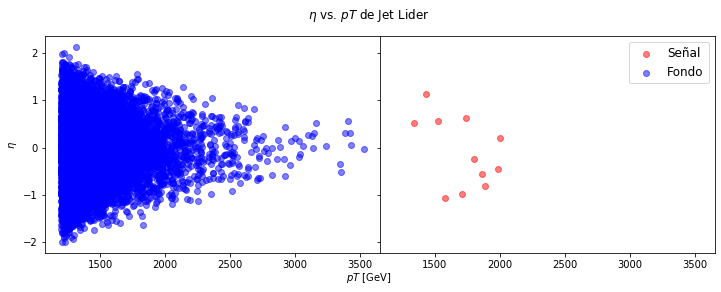

In [39]:
# Relación entre eta y pT

plots_scatter(leadpT['fondo'], leadeta['fondo'], 
              leadpT['senal'], leadeta['senal'], 
              r'$pT$ [GeV]', r'$\eta$', r'$\eta$ vs. $pT$ de Jet Lider')

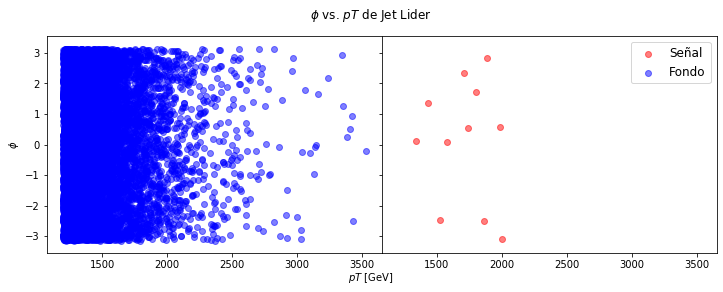

In [40]:
# Relación entre phi y pT

plots_scatter(leadpT['fondo'], leadphi['fondo'], 
              leadpT['senal'], leadphi['senal'], 
              r'$pT$ [GeV]', r'$\phi$', r'$\phi$ vs. $pT$ de Jet Lider')

### Relación de $\phi$ con las demás variables

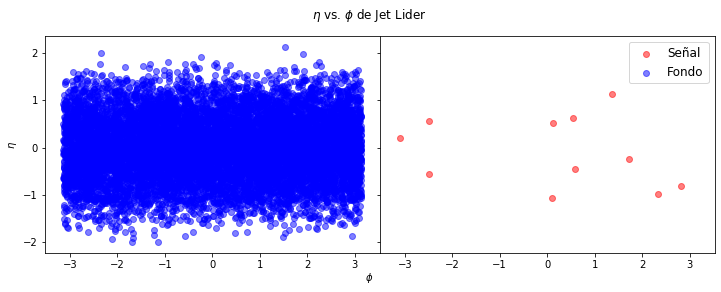

In [41]:
# Relación entre eta y phi

plots_scatter(leadphi['fondo'], leadeta['fondo'], 
              leadphi['senal'], leadeta['senal'], 
              r'$\phi$', r'$\eta$', r'$\eta$ vs. $\phi$ de Jet Lider')